In [1]:
import multiprocessing as mp
import os, sys
import time
from multiprocessing.context import Process

import cv2

from text_renderer.config import get_cfg, GeneratorCfg
from text_renderer.dataset import ImgDataset
from text_renderer.render import Render
import matplotlib.pyplot as plt
import numpy as np

sys.path.append('../')

from playdict_ocr.datasets import RecognizationDataset

In [2]:
from text_renderer.corpus import Corpus
from playdict_ocr.word_generator import WordGenerator

class GameOcrCorpus(Corpus):
    def __init__(self, cfg):
        super().__init__(cfg)
        self.wg = WordGenerator()

    def get_text(self):
        return self.wg.generate_word()

In [3]:
from text_renderer.effect import *
from text_renderer.corpus import *
from text_renderer.config import (
    RenderCfg,
    NormPerspectiveTransformCfg,
    GeneratorCfg,
    SimpleTextColorCfg,
)

In [4]:
import pathlib

render_cfg,=RenderCfg(
    bg_dir=pathlib.Path("bg"),
    height=32,
    perspective_transform=NormPerspectiveTransformCfg(20, 20, 1.5),
    corpus=GameOcrCorpus(
        RandCorpusCfg(
            font_dir=pathlib.Path("font"),
            font_size=(16, 30),
        ),
    ),
    gray=True
),

render = Render(render_cfg)

In [5]:
target_width = 144

def generate_img():
    img, label = render()

    # random flip
    if np.random.uniform(0, 1) > 0.5:
        img = 255 - img

    '''
    h, w = img.shape
    w_delta = w - target_width
    if w_delta < 0:
        img = np.pad(img, ((0,0), (-w_delta//2, -w_delta//2)), constant_values=np.mean(img))
    '''

    pad_cnt = np.random.randint(0, target_width//8, size=[2, 2])
    img = np.pad(img, pad_cnt, constant_values=np.mean(img))
    img = cv2.resize(img, (target_width, 32))

    return img, label

In [6]:
def show_img(img, label=None):
    plt.imshow(img)
    plt.ylim(32, 0)
    if label is not None:
        plt.title(label)

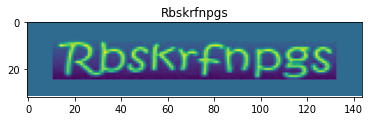

In [7]:
show_img(*generate_img())

In [8]:
from tqdm import tqdm
import multiprocessing.dummy as mp

cnt = 2000000

data, tgt = [], []

def loop_body(_):
    img, label = generate_img()
    data.append(img)
    tgt.append(label)

with mp.Pool(8) as p:
    with tqdm(total=cnt) as pbar:
        for _ in p.imap_unordered(loop_body, range(cnt)):
            pbar.update()

dataset = RecognizationDataset(data, tgt)

  0%|          | 1542/2000000 [00:15<4:36:56, 120.27it/s]

In [ ]:
dataset.to_pickle('synth_0.pkl')